In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gpflow

from vbpp.model import VBPP
from data_down_events_training import make_estimate_data_for_down

def build_data(user, start_line, end_line, filename):
    num_observations = end_line - start_line
    #events = make_estimate_data_for_down(user, start_line, end_line, filename)
    df_oral = pd.read_excel(filename, header=0)
    df = df_oral[df_oral['subject']==user]
    events = df['cumulat_time'][start_line:end_line].tolist()
    
    return events, num_observations

def domain_grid(domain, num_points):       #域grid
    return np.linspace(domain.min(axis=1), domain.max(axis=1), num_points)

def domain_area(domain):                   #域面积
    return np.prod(domain.max(axis=1) - domain.min(axis=1))

def build_model(events, domain, num_observations, M=20, variance = 1.0, lengthscales = 0.1):
    #kernel = gpflow.kernels.SquaredExponential()
    kernel = gpflow.kernels.SquaredExponential(variance = variance, lengthscales = lengthscales)  #0.01,0.05,0.1,0.2
    Z = domain_grid(domain, M)                               #均匀切分domain,和events无关
    feature = gpflow.inducing_variables.InducingPoints(Z)    #inducing point（将均匀切分的点作为inducing point）
    q_mu = np.zeros(M)      #均值为0？
    q_S = np.eye(M)         #单位矩阵
    #print (events)
    num_events = len(events)
    beta0 = np.sqrt(num_events / domain_area(domain))       # 事件数/域面积 的开方,是什么？  是第二个模型的offset
    model = VBPP(feature, kernel, domain, q_mu, q_S, beta0=beta0, num_events=num_events, num_observations = num_observations)
    return model

In [69]:
'''
subject = 's019'

#读取s019的样本
filename = "./data/DD_output_new.xls"
df_oral = pd.read_excel(filename, header=0)

df_subject = df_oral[(df_oral['subject']==subject) &(df_oral['sessionIndex']==1) ]

screenIndex_list = df_subject['screenIndex'].unique().tolist()

cumulate_time_list = []
key_list = []

for _,screenIndex in enumerate(screenIndex_list):
    key_temp = []
    key_temp_list = []
    df_detail = df_subject[df_subject['screenIndex']==screenIndex]
    time = pd.DataFrame(df_detail['cumulat_time'].tolist())    
    cumulate_time_list.append(time)
    for i in range(len(df_detail)):
        key_temp = df_detail.iloc[i,5]+'_'+df_detail.iloc[i,6]
        key_temp_list.append(key_temp)
    key_list.append(key_temp_list)
'''    


In [4]:
def raw_data(subject,input_file,sessionIndex):
    df_oral = pd.read_excel(filename, header=0)
    df_subject = df_oral[(df_oral['subject']==subject) &(df_oral['sessionIndex']==sessionIndex) ]

    screenIndex_list = df_subject['screenIndex'].unique().tolist()

    cumulate_time_list = []
    key_list = []

    for _,screenIndex in enumerate(screenIndex_list):
        key_temp = []
        key_temp_list = []
        df_detail = df_subject[df_subject['screenIndex']==screenIndex]
        time = pd.DataFrame(df_detail['cumulat_time'].tolist())    
        cumulate_time_list.append(time)
        for i in range(len(df_detail)):
            key_temp = df_detail.iloc[i,5]+'_'+df_detail.iloc[i,6]
            key_temp_list.append(key_temp)
        key_list.append(key_temp_list)
    return cumulate_time_list,key_list

In [7]:
def fit_and_predict(events,object_user,variance,lengthscales,inducing_num,N):  #N是预测点个数
    events = np.array(events, float).reshape(-1, 1)
    num_observations = len(events)
    lamda = []
    
    domain_min = min(events)
    domain_max = max(events)
    domain = [domain_min,domain_max]
    domain = np.array(domain, float).reshape(1, 2)
    
    model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

    def objective_closure():                           #目标函数
        return - model.elbo(events)
    
    gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

    #画强度的估值图
    X = domain_grid(domain, N)
    lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
    #lamda.append(lambda_mean[-1].numpy())
    lamda.append(lambda_mean.numpy().flatten())
    return lamda   

In [8]:
subject = 's019'
filename = "./data/DD_output_new.xls"
variance = 1.0
lengthscales = 1.0
inducing_num = 20
N = 1000
sessionIndex = 1

cumulate_time,key_list = raw_data(subject = subject, input_file = filename, sessionIndex = sessionIndex)

lamda_list = []

for _,cumulates in enumerate(cumulate_time):
    lamda = fit_and_predict(events = cumulates, object_user = subject, variance = variance, \
                            lengthscales = lengthscales, inducing_num = inducing_num,N=N)
    lamda_list.append(lamda)

#lamda_list   

[[array([0.0278475 , 0.02788228, 0.02790259, 0.0279082 , 0.0278989 ,
         0.02787457, 0.0278351 , 0.02778046, 0.02771063, 0.02762568,
         0.02752573, 0.02741091, 0.02728146, 0.02713762, 0.02697973,
         0.02680813, 0.02662324, 0.02642553, 0.0262155 , 0.02599371,
         0.02576074, 0.02551724, 0.02526387, 0.02500133, 0.02473038,
         0.02445176, 0.02416628, 0.02387475, 0.023578  , 0.02327688,
         0.02297224, 0.02266497, 0.02235592, 0.02204598, 0.02173602,
         0.0214269 , 0.02111949, 0.02081462, 0.02051314, 0.02021585,
         0.01992356, 0.01963702, 0.019357  , 0.0190842 , 0.01881931,
         0.018563  , 0.01831589, 0.01807858, 0.01785162, 0.01763555,
         0.01743085, 0.01723797, 0.01705734, 0.01688934, 0.01673432,
         0.0165926 , 0.01646445, 0.01635013, 0.01624986, 0.01616381,
         0.01609215, 0.016035  , 0.01599248, 0.01596464, 0.01595154,
         0.01595321, 0.01596966, 0.01600085, 0.01604677, 0.01610733,
         0.01618248, 0.01627211, 0

ValueError: setting an array element with a sequence.

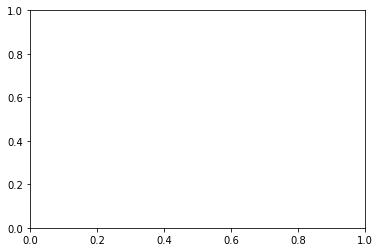

In [13]:
df_plot = pd.DataFrame(lamda_list)
plt.plot(df_plot)

In [6]:
events,num_observations = build_data(object_user,object_data_str, object_data_end,filename)

In [8]:
num_observations

100